# Getting started with Diffusion MRI data analysis in dipy

In this first tutorial, we will familiarise ourselves with diffusion data. If you are comfortable with working with diffusion data, feel free to run through this section quickly or skip over to Tutorial 2.

First, we will set up the paths required to load the data and inspect the contents of the dwi folder for one dataset (sub-CON01). After running the code in the shell below, you should see a set of files that are obtained from a typical diffusion MRI acquisition. This includes a nii.gz dwi data file, as well as .bval and .bvec files that contain the information on the diffusion-sensitising magnetic field gradients.

In [1]:
import os
scripts_dir = os.getcwd()
bids_dir = "../data/bids"
out_dir = "../data/derivatives"

sub='01'

#define path to dwi data
dwi_path = f"{bids_dir}/sub-{sub}/dwi"

#list files in dwi directory
for item in os.listdir(dwi_path):
    print(item)




sub-01_acq-PA_dwi.nii
sub-01_acq-AP_dwi.json
sub-01_acq-AP_dwi.bvec
sub-01_acq-AP_dwi.bval
sub-01_acq-PA_dwi.json
sub-01_acq-AP_dwi.nii


The bval file contains a scalar value for each applied gradient, corresponding to the respective b-value. bvec contains a 3x1 vector for each gradient, indicating the gradient direction. The entries in bval and bvec are as many as the number of volumes in the .nii file. So the ith volume in the data corresponds to a measurement obtained after applying a diffusion-sensitising gradient with a b-value given by the ith entry in bval and a gradient direction given by the ith vector in bvec. 

## Loading the data

There are two sets of data in this folder, one labelled AP and another one PA. For now we will focus on the AP data, but the differences between the two sets of data will be discussed in Tutorial 2. 

In [2]:
#import the relevant modules
import numpy as np
import dipy
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti


In [3]:
#find the relevant files and save file names into specific variables

for item in os.listdir(dwi_path):
    if item.endswith('AP_dwi.nii'):
        dwi_ap_file = item
    if item.endswith('AP_dwi.bvec'):
        dwi_ap_bvec = item
    if item.endswith('AP_dwi.bval'):
        dwi_ap_bval = item
    if item.endswith('PA_dwi.nii'):
        dwi_pa_file = item


#load the dwi raw data for phase encoding direction AP
dwi_ap_data, dwi_ap_affine = load_nifti(f"{dwi_path}/{dwi_ap_file}")

#load bvals and bevecs for phase encoding direction AP
bvals, bvecs = read_bvals_bvecs(f"{dwi_path}/{dwi_ap_bval}", f"{dwi_path}/{dwi_ap_bvec}")



Having loaded the AP_dwi data, and the corresponding bval and bvec files, we can now inspect the shape of each variable to check there are no inconsisencies. The fourth dimension of the data (number of dwi volumes) should match the first dimension for the variables bvals and bvecs. 

In [4]:
#print shape of variable dwi_ap_data, bvals and bvecs
print(f"The shape of the data is: {dwi_ap_data.shape}")
print(f"The shape of the bvals is: {bvals.shape}")
print(f"The shape of the bvecs is: {bvecs.shape}")

The shape of the data is: (96, 96, 66, 63)
The shape of the bvals is: (63,)
The shape of the bvecs is: (63, 3)


We can also inspect the contents of the bvals file:

In [5]:
#inspect contents of bval file
print(bvals)

#list the unique bvals
print(f"There are {len(np.unique(bvals))} unique b-values: {np.unique(bvals)}")

[   0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.    0. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
There are 3 unique b-values: [   0. 1000. 2000.]


Next, we can plot specific slices from the DWI data using matplotlib. 

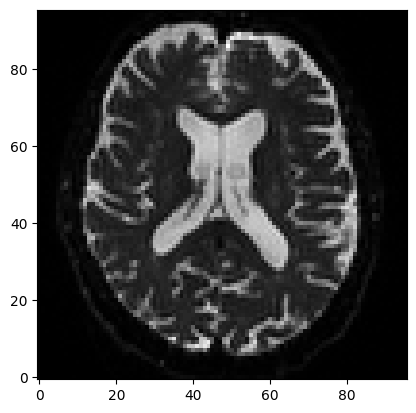

In [6]:
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

#select the middle slice 
mid_slice = dwi_ap_data.shape[2] // 2

#plot the middle slice from a b=0 volume
vol_idx = 0

plt.imshow(dwi_ap_data[:,:,mid_slice,vol_idx].T, cmap='gray', origin='lower')


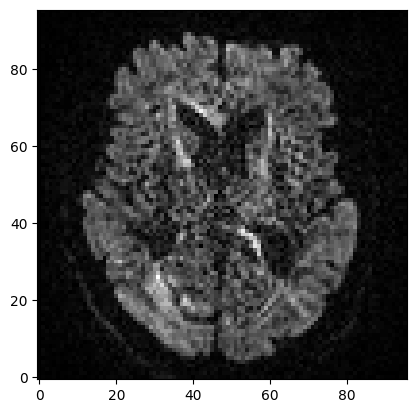

In [7]:
#plot the middle slice from a b=2000 volume
slice_idx = 30
vol_idx = 33

plt.imshow(dwi_ap_data[:,:,slice_idx,vol_idx].T, cmap='gray', origin='lower')

For data analysis in dipy we also need to create the gradient table object, which combines the information from the bvals and bvecs file. 

In [8]:
#create the gradient table object

from dipy.core.gradients import gradient_table

gtab = gradient_table(bvals, bvecs)

The gtab object can be useful to quickly inspect information about the data. For example, the attribute "b0s_mask" returns a bolean array showing which volumes corresponde to b=0 acquisitions:

In [9]:
print(gtab.b0s_mask)

[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


## EPI distortions and phase-encode direction

Earlier we noted that there were two sets of diffusion MRI data, one labelled AP and another one labelled PA. Each set corresponds to a different phase-encode direction: the AP dataset was collected in the anterior to posterior direction, while the PA data was collected with the reversed phase-encode direction. In order to better understand the effect of phase-encode direction on the data, we will plot the same slice for the AP and PA datasets side by side, for a volume without diffusion weighting (b=0 s/mm2). 

Text(0.5, 1.0, 'PA dwi data, b-value = 0 s/mm2')

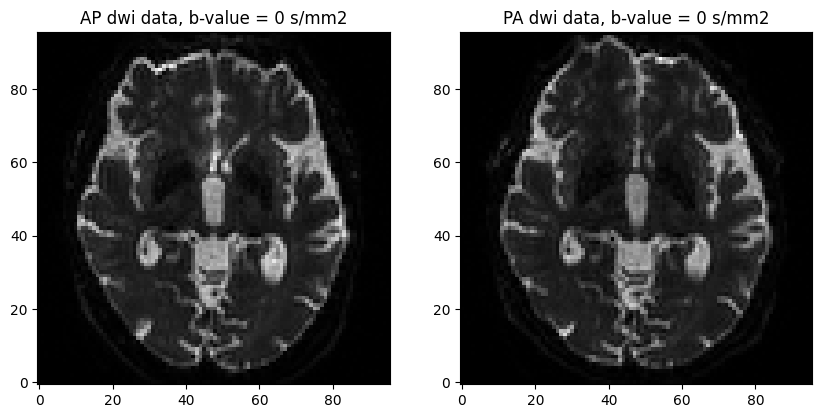

In [10]:
#load the dwi raw data for phase encoding direction PA
dwi_pa_data, dwi_pa_affine = load_nifti(f"{dwi_path}/{dwi_pa_file}")

#plot slice 25 of the dwi data for phase encoding direction AP and PA
slice_idx = 25

#set up the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].imshow(dwi_ap_data[:,:,slice_idx, 0].T, cmap='gray', origin='lower')
axes[0].set_title(f"AP dwi data, b-value = 0 s/mm2")

axes[1].imshow(dwi_pa_data[:,:,slice_idx].T, cmap='gray', origin='lower')
axes[1].set_title(f"PA dwi data, b-value = 0 s/mm2")

Notice that as you go to more inferior slices (e.g. slice number 25), the frontal part of the brain starts to appear distorted (e.g. "squashed" or "elongated"). These distortions are always present in EPI images and are caused by differences in the magnetic susceptibilities of the areas being imaged. Regions that are squashed in the AP data appear elongated in the PA data and vice versa. In Tutorial 2 we will correct these distortions by combining the two b=0 images, as part of the pre-processing pipeline. 

# Exercises 

1. Calculate and plot the mean of all b=0 volumes (Hint: use the np.mean() method.) 

2. Plot the middle slice for a volume corresponding to each of the three b-values: 0, 1000 and 2000 s/mm2. (Hint: use the plt.subplot() method to create subplots.) 